In [65]:
import yfinance as yf

data = yf.download(tickers = "6C=F", start="2017-12-01", end="2023-06-16", interval='1d')

[*********************100%***********************]  1 of 1 completed


In [66]:
data = data.reset_index('Date', inplace=False)

In [67]:
df = data

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [69]:
df1=df.reset_index()['Close']

In [70]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [71]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [72]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [73]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [74]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [75]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [76]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 6s 168ms/step - loss: 0.1122 - val_loss: 0.0170
Epoch 2/100
14/14 [==============================] - 3s 209ms/step - loss: 0.0176 - val_loss: 0.0139
Epoch 3/100
14/14 [==============================] - 3s 191ms/step - loss: 0.0107 - val_loss: 0.0094
Epoch 4/100
14/14 [==============================] - 2s 144ms/step - loss: 0.0073 - val_loss: 0.0080
Epoch 5/100
14/14 [==============================] - 2s 135ms/step - loss: 0.0058 - val_loss: 0.0077
Epoch 6/100
14/14 [==============================] - 2s 131ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 7/100
14/14 [==============================] - 2s 142ms/step - loss: 0.0034 - val_loss: 0.0056
Epoch 8/100
14/14 [==============================] - 3s 213ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 9/100
14/14 [==============================] - 3s 182ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 10/100
14/14 [==============================] - 2s 133ms/step - loss: 0.0025 - val_lo

In [77]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 24ms/step


In [78]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [79]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [80]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.003964227090117726
Testing RMSE: 0.004750448712462271


In [81]:
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 0.003033909358476332
Testing MAE: 0.0037582381205125237


In [82]:
from sklearn.metrics import mean_absolute_percentage_error

In [83]:
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', valid_rmse)
print('Testing MAPE:', test_rmse)

Validation MAPE: 0.003964227090117726
Testing MAPE: 0.004750448712462271


In [85]:
x_input = val_data[40:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[:n_steps])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[n_steps:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        if len(temp_input) > 0:
            x_input = np.array(temp_input)
            x_input = x_input.reshape(1, len(temp_input), 1)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i, yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        i += 1


0 day output [[0.4551571]]
1 day output [[0.47884545]]
2 day output [[0.4722085]]
3 day output [[0.46757483]]
4 day output [[0.4762966]]
5 day output [[0.472222]]
6 day output [[0.47283095]]
7 day output [[0.48036256]]
8 day output [[0.4779287]]
9 day output [[0.48567253]]
10 day output [[0.48733294]]
11 day output [[0.49075428]]
12 day output [[0.49468133]]
13 day output [[0.49861854]]
14 day output [[0.5005551]]
15 day output [[0.50670147]]
16 day output [[0.5070682]]
17 day output [[0.5129246]]
18 day output [[0.5133136]]
19 day output [[0.51808023]]
20 day output [[0.5187525]]
21 day output [[0.5241312]]
22 day output [[0.52361894]]
23 day output [[0.5279817]]
24 day output [[0.5259606]]
25 day output [[0.53063744]]
26 day output [[0.5283783]]
27 day output [[0.5328708]]
28 day output [[0.532027]]
29 day output [[0.534374]]


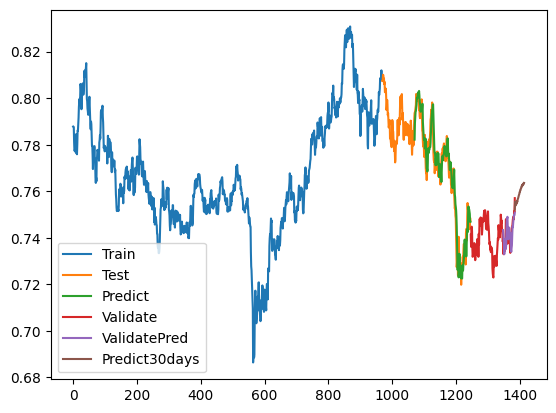

In [86]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [88]:
scaler.inverse_transform(lst_output)

array([[0.75215193],
       [0.75557134],
       [0.7546133 ],
       [0.75394443],
       [0.75520342],
       [0.75461525],
       [0.75470315],
       [0.75579034],
       [0.75543901],
       [0.75655683],
       [0.75679651],
       [0.75729038],
       [0.75785725],
       [0.75842559],
       [0.75870513],
       [0.75959236],
       [0.7596453 ],
       [0.76049067],
       [0.76054682],
       [0.76123488],
       [0.76133193],
       [0.76210834],
       [0.76203439],
       [0.76266416],
       [0.76237242],
       [0.76304752],
       [0.76272141],
       [0.7633699 ],
       [0.7632481 ],
       [0.76358689]])